In [299]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [300]:
# notes: Constant BCs and Sources go on RHS. Diffusion terms go in matrix

In [301]:
class Point_Source(object):
    def __init__(self, _node, _value):
        self.node = _node
        self.value = _value

In [302]:
class Continuous_Source(object):
    def __init__(self, _x_upper, _x_lower, _y_upper, _y_lower, _strength):
        self.x_upper = _x_upper
        self.x_lower = _x_lower
        self.y_upper = _y_upper
        self.y_lower = _y_lower
        self.strength = _strength

In [303]:
class Grid(object):
    def __init__(self, _Lx=1, _Ly=1, _point_sources=[], _continuous_sources=[],
                 _left_BC=0, _right_BC=1, _type_one_BCs_on=True):
        self.elements = list(range(1,19))
        self.nodes = list(range(1,17))
        # we make the node values list one longer than it needs to be to not 
        # have to deal with 1 indexing instead of 0 indexing
        self.node_values = [0] * 17
        if _type_one_BCs_on:
            self.left_edge_nodes = [1,5,9,13]
            self.right_edge_nodes = [4,8,12,16]
        else:
            self.left_edge_nodes = []
            self.right_edge_nodes = []
        self.point_sources = _point_sources
        self.continuous_sources = _continuous_sources
        self.Lx = _Lx
        self.Ly = _Ly
        self.left_BC = _left_BC
        self.right_BC = _right_BC
        self.elemental_area = (_Lx*_Ly)/len(self.elements)

    def nodes_associated_with_element(self, element):
        square = math.floor((float(element)+1.0)/2.0)
        row = math.floor((square-.5)/3.0)
        is_upper_triangle = element%2
        lower_left_node = int(square + row)
        upper_right_node = lower_left_node + 5
        third_node = lower_left_node + 1
        if is_upper_triangle:
            third_node = upper_right_node - 1
        return sorted([lower_left_node,third_node,upper_right_node])
    
    def empty_matrix(self):
        matrix = []
        for _ in self.nodes:
            matrix.append([0]*len(self.nodes))
        return matrix
    
    # TODO for each case determine to use dx or dy for T
    def calculate_diffusion_term(self, node_1, node_2, element):
        NUM_CELLS_PER_ROW = 3.0
        dx = self.Lx/NUM_CELLS_PER_ROW
        if node_1 == node_2:
            return (dx**2.0)/(2.0*self.elemental_area**2.0)
        else:
            if self.nodes_are_seperated_by_long_edge(node_1, node_2):
                return 0
            else:
                return -(dx**2.0)/(4.0*self.elemental_area**2.0)
    
    def nodes_are_seperated_by_long_edge(self, node_1, node_2):
        return abs(node_1-node_2) == 5

    # TODO calculate this
    def percent_overlap(continuous_source, element):
        return 1
    
    # need to adjust this for how much of the element is being overlapped by the source
    # For now we assume the continuous source is a constant
    # This can go in the vector not the matrix
    def calculate_continuous_source_term(self, element, continuous_source):
        return self.elemental_area * continuous_source.strength * self.percent_overlap(element, continuous_source)
    
    def assemble_right_hand_side(self):
        vector = [0] * len(self.nodes)
        # add type 1 BCs
        for node in self.left_edge_nodes:
            vector[node-1] = self.left_BC
        for node in self.right_edge_nodes:
            vector[node-1] = self.right_BC
        # add point sources
        for point_source in self.point_sources:
            vector[point_source.node-1] = point_source.value 
        # for element in self.elements:
        #     for continuous_source in self.continuous_sources:
        #         vector[element] += self.calculate_continuous_source_term(element, continuous_source)
        return vector


    def assemble_matrix(self):
        matrix = self.empty_matrix()
        # do elemental integrals
        for element in self.elements:
            nodes = self.nodes_associated_with_element(element)
            for node_1 in nodes:
                for node_2 in nodes:
                    contribution = self.calculate_diffusion_term(node_1, node_2, element)
                    matrix[node_1-1][node_2-1] += contribution
        # add type one BCs
        for node in self.left_edge_nodes:
            matrix[node-1] = [0]*len(self.nodes)
            matrix[node-1][node-1] = 1
        for node in self.right_edge_nodes:
            matrix[node-1] = [0]*len(self.nodes)
            matrix[node-1][node-1] = 1
        # add type 2 BCs

        # add point source/sink terms
        for point_source in self.point_sources:
            matrix[point_source.node-1] = [0]*len(self.nodes)
            matrix[point_source.node-1][point_source.node-1] = 1
        return matrix

    def solve_system(self):
        A = self.assemble_matrix()
        b = self.assemble_right_hand_side()
        self.node_values = [0] + list(np.linalg.solve(A,b))
    
    def print_system(self):
        printing_grid = np.zeros((4,4))
        for node in self.nodes:
            node_value = self.node_values[node]
            y = 3 - math.floor((node-1)/4)
            x = (node-1) % 4
            printing_grid[y][x] = node_value
        ax = sns.heatmap(printing_grid, linewidth=0.5,cmap="YlGnBu")
        plt.title("Graph of node values")
        plt.show()

        


In [304]:
grid = Grid()

In [305]:
# Nodes associated with element test
assert grid.nodes_associated_with_element(1) == [1,5,6]
assert grid.nodes_associated_with_element(2) == [1,2,6]
assert grid.nodes_associated_with_element(7) == [5,9,10]
assert grid.nodes_associated_with_element(8) == [5,6,10]

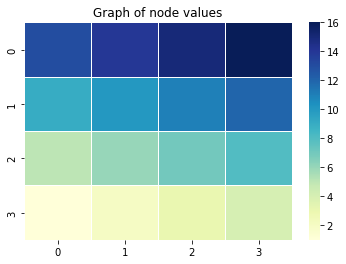

In [306]:
grid.node_values = [0] + list(range(1,17))
grid.print_system()


In [307]:
# print(nodes)
matrix = grid.assemble_matrix()
print(matrix)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-9.0, 54.0, -9.0, 0, 0, -18.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -9.0, 54.0, -9.0, 0, 0, -18.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -18.0, 0, 0, -18.0, 108.0, -18.0, 0, 0, -18.0, 0, 0, 0, 0, 0, 0], [0, 0, -18.0, 0, 0, -18.0, 108.0, -18.0, 0, 0, -18.0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -18.0, 0, 0, -18.0, 108.0, -18.0, 0, 0, -18.0, 0, 0], [0, 0, 0, 0, 0, 0, -18.0, 0, 0, -18.0, 108.0, -18.0, 0, 0, -18.0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, -18.0, 0, 0, -9.0, 54.0, -9.0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -18.0, 0, 0, -9.0, 54.0, -9.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]


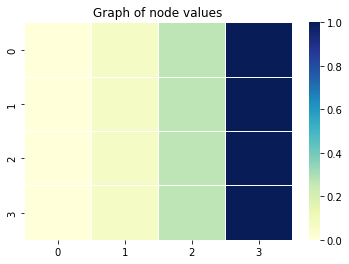

In [308]:
# Only type 1 bcs on
grid = Grid()
grid.solve_system()
grid.print_system()

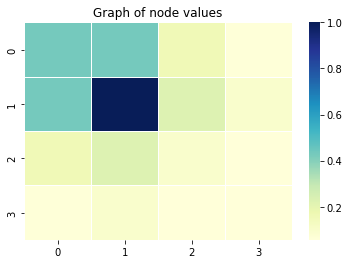

In [310]:
# Only 
point_sources =[ 
    Point_Source(_node=7,_value=1),
    Point_Source(_node=10,_value=1)
]
grid = Grid(_point_sources=point_sources, _right_BC=0, _type_one_BCs_on = False)
grid.solve_system()
grid.print_system()